<a href="https://colab.research.google.com/github/Yarida2543/weatherwise.Yarida/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [124]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
# !pip install hands-on-ai
# !pip install pyinputplus


In [125]:
import os

# # Configure your provider
# os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
# os.environ['HANDS_ON_AI_MODEL'] = 'llama3.2'
# os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ') # DEMO API '88b4bd057b654b60af65bb248c944244.TyY60d2n08CBPetkeY71GwEv'
# os.environ["WEATHER_API_KEY"] = "220e281f356576ed04365173258a3eb1"  # Demo API

# from hands_on_ai.chat import get_response
# print(get_response("As a current weather in Australia, Perth today is 25 degrees celcius, with uv index of, and partial clouds, Can I swim in the pool?"))

## 📦 Setup and Configuration
Import required packages and setup environment.

In [126]:
# Import required packages and setup environment
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union, TypedDict
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime
import time
import json
from datetime import datetime, timedelta


# Global state used by UI/demo
Forecast_Location: Optional[str] = None
Forecast_Day: int = 5
Forecast_Weather: Optional[Dict[str, Any]] = None

# Helper for safe matplotlib
plt.rcParams.update({
        "figure.figsize": (8, 4),
        "axes.grid": True,
})

## 🌤️ Weather Data Functions

In [127]:
# Define get_weather_data() function here

class ParsedWeather(TypedDict, total=False):
        location: str
        forecast_days: int
        error: Optional[str]
        current: Dict[str, Any]
        daily: List[Dict[str, Any]]

def Get_data_from_Web (city: str, units: str = "metric"):
        """
        Fetches weather data from the OpenWeatherMap API.

        Args:
            city (str): The name of the city for which to fetch weather data.
            units (str, optional): The units for temperature and wind speed ('metric' for Celsius and km/h, 'imperial' for Fahrenheit and miles/h). Defaults to "metric".

        Returns:
            dict: A dictionary containing the weather data from the API, or an error dictionary if an error occurs.
        """
        api_key = os.getenv("WEATHER_API_KEY")
        if not api_key:
                print("Error: WEATHER_API_KEY not found in environment variables.")
                return {"error": "WEATHER_API_KEY not configured."}

        try:
                # Construct the API URL
                base_url = "https://api.openweathermap.org/data/2.5/forecast"
                # Using f-string for cleaner URL construction
                url = f"{base_url}?q={city}&appid={api_key}&units={units}"

                # Make the API request
                response = requests.get(url)
                response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

                # Parse the JSON response
                data = response.json()
                return data

        except requests.exceptions.RequestException as e:
                # Handle request-specific errors (e.g., network issues, invalid URL, HTTP errors)
                print(f"Error fetching weather data: {e}")
                return {"error": f"Error fetching weather data: {e}"}
        except Exception as e:
                # Handle any other unexpected errors
                print(f"An unexpected error occurred: {e}")
                return {"error": f"An unexpected error occurred: {e}"}

def _process_daily_forecast_items(day_items: List[Dict[str, Any]], date_str: str) -> Optional[Dict[str, Any]]:
    """
    Processes a list of hourly forecast items for a single day to create a daily summary.

    Args:
        day_items (List[Dict[str, Any]]): List of hourly forecast dictionaries for a specific day.
        date_str (str): The date string for the day (YYYY-MM-DD).

    Returns:
        Optional[Dict[str, Any]]: A dictionary containing the daily weather summary,
                                   or None if no items are provided for the day.
    """
    if not day_items:
        return None

    # Calculate max/min temperature and total precipitation
    maximum_temperature = max(item["main"]["temp_max"] for item in day_items)
    minimum_temperature = min(item["main"]["temp_min"] for item in day_items)
    # OpenWeatherMap gives rain in 3h intervals, sum them up for the day
    total_precip_mm = sum(item.get("rain", {}).get("3h", 0) for item in day_items)

    # Find a representative weather description (e.g., from the item closest to midday)
    representative_item = None
    min_diff = float('inf')
    for item in day_items:
        time_str = item["dt_txt"].split(" ")[1]
        hour = int(time_str.split(":")[0])
        diff = abs(hour - 12) # Closest to midday (12:00)
        if diff < min_diff:
            min_diff = diff
            representative_item = item

    weather_description = (representative_item.get("weather", [{}])[0].get("description", "")) if representative_item else ""

    # Return the aggregated daily forecast data
    return {
        "date": date_str,  # The date of the forecast
        "maxtemperature": str(round(maximum_temperature, 2)), # Maximum temperature for the day in Celsius (stored as string)
        "mintemperature": str(round(minimum_temperature, 2)), # Minimum temperature for the day in Celsius (stored as string)
        "totalPrecipitation": str(round(total_precip_mm, 2)), # Total precipitation for the day in mm (stored as string)
        "weatherDescript": [{"value": weather_description}] # Main weather description for the day (stored as list of dicts)
        # Add other fields if needed by visualization or summary functions
    }


def get_weather_data(city: str, forecast_days: int = 5):
        """
        Retrieve weather data for a specified location.

        Args:
                location (str): City or location name
                forecast_days (int): Number of days to forecast (1-5)

        Returns:
                dict: Weather data including current conditions and forecast
        """
        result: ParsedWeather = {
              "location": city,
              "forecast_days": max(1, min(int(forecast_days or 5), 5)),
        }

        # Validate the city input: must be a non-empty string
        if not city or not isinstance(city, str):
              result["error"] = "Invalid location provided. Please enter a city name."
              return result


        response_data = Get_data_from_Web(city=city, units="metric")

        if response_data and "list" in response_data:
            daily_forecasts: List[Dict[str, Any]] = []

            # Group data by day
            daily_data: Dict[str, List[Dict[str, Any]]] = {}
            for item in response_data["list"]:
                date_str = item["dt_txt"].split(" ")[0]
                if date_str not in daily_data:
                    daily_data[date_str] = []
                daily_data[date_str].append(item)

            # Determine the dates to include in the forecast based on forecast_days
            from datetime import datetime, timedelta
            today = datetime.now().date()
            dates_to_include = [(today + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(result["forecast_days"])]

            # Process data for each included date using the helper function
            for date_str in dates_to_include:
                if date_str in daily_data:
                    day_items = daily_data[date_str]
                    daily_summary = _process_daily_forecast_items(day_items, date_str)
                    if daily_summary:
                        daily_forecasts.append(daily_summary)

            result["daily"] = daily_forecasts

            # For current data, OpenWeatherMap has a separate endpoint, but for simplicity,
            # we can try to extract the first available forecast entry if it's for today.
            if response_data["list"]:
                 first_item = response_data["list"][0]
                 if first_item["dt_txt"].split(" ")[0] == today.strftime("%Y-%m-%d"):
                     result["current"] = {
                         "temp_C": first_item["main"]["temp"],
                         "FeelsLike": first_item["main"]["feels_like"],
                         "weatherDescript": first_item["weather"],
                         "precipi_MM": first_item.get("rain", {}).get("3h", 0), # Precipitation in last 3 hours
                         "windspeed": first_item["wind"]["speed"] * 3.6, # Convert m/s to km/h
                         "wind_degrees": None # OpenWeatherMap provides degrees, not 16-point
                     }


        elif response_data and response_data.get("error"):
             result["error"] = response_data["error"]
        else:
             result["error"] = "Missed to recover the weather forecast data."


        return result

## 📊 Visualisation Functions

In [128]:
# Define create_temperature_visualisation()

def _format_day_label(date_str: Optional[str]) -> str:
    """
    Formats a date string into a "Weekday Day" label (e.g., "Mon 01").
    Handles potential errors in parsing or formatting.

    Args:
        date_str (Optional[str]): The date string to format.

    Returns:
        str: The formatted date label or "Unknown Date" if formatting fails.
    """
    if not date_str:
        return "Unknown Date"

    try:
        # Attempt to parse the date string and format it as "Weekday Day" (e.g., "Mon 01")
        # Assuming input format is YYYY-MM-DD
        return datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d")
    except ValueError:
        # If parsing fails due to incorrect format, return the original date string
        return str(date_str)
    except Exception:
        # Catch any other unexpected errors during formatting
        return str(date_str)


def day_labels(daily: List[Dict[str, Any]]) -> List[str]:
        """
        Extracts formatted day and date labels from daily weather data for plotting.

        Args:
            daily (List[Dict[str, Any]]): A list of dictionaries containing daily weather data.

        Returns:
            List[str]: A list of formatted strings representing the day and date (e.g., "Mon 01").
        """
        labels: List[str] = []
        # Iterate through each day's weather data
        for d in daily:
                # Attempt to get the date from the 'date' key first,
                # or fall back to the 'sunrise' time in the 'astronomy' data if 'date' is not available.
                # We'll take just the date part if sunrise includes time.
                date_str = d.get("date")
                if not date_str and d.get("astronomy") and d["astronomy"] and d["astronomy"][0].get("sunrise"):
                     full_datetime_str = d["astronomy"][0]["sunrise"]
                     try:
                          # Assuming 'sunrise' is in a format that can be split by space
                          date_str = full_datetime_str.split(" ")[0]
                     except Exception:
                           date_str = full_datetime_str # Fallback to full string if splitting fails


                # Format the extracted date string using the helper function
                labels.append(_format_day_label(date_str))


        return labels

def create_temperature_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
        """
        Create visualisation of temperature data.

        Args:
                weather_data (dict): The processed weather data
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """

        # Get the daily forecast data. If no data is available, print an error and return.
        daily_forecast_data = weather_data.get("daily", [])
        if not daily_forecast_data:
                print("No data to forecast temperatures plot.")
                return None

        # Extract maximum temperatures for each day. Use 0 if the data is missing or invalid.
        maximum_temperatures = [float(d.get("maxtemperature", 0) or 0) for d in daily_forecast_data]

        # Extract minimum temperatures for each day. Use 0 if the data is missing or invalid.
        minimum_temperatures = [float(d.get("mintemperature", 0) or 0) for d in daily_forecast_data]

        # Get the formatted labels for the x-axis (days) using the helper function.
        day_labels_list = day_labels(daily_forecast_data)

        # --- Create the temperature plot using Matplotlib ---
        fig, ax = plt.subplots() # Create a figure and a set of axes for the plot.

        # Plot the maximum temperature line with circular markers.
        ax.plot(day_labels_list, maximum_temperatures, marker='o', label='Maximum Temperature (celsius)')

        # Plot the minimum temperature line with circular markers.
        ax.plot(day_labels_list, minimum_temperatures, marker='o', label='Minimum Temperature (celsius)')

        # Set the title of the plot for clarity.
        ax.set_title("Temperature Forecast in daily")

        # Set the label for the x-axis (Day of the forecast).
        ax.set_xlabel("Day and Date")

        # Set the label for the y-axis (Temperature in Celsius).
        ax.set_ylabel("Temperature (celsius)")

        # Display the legend to show what each line represents (Max/Min Temperature).
        ax.legend()

        # Set the rotation of the x-axis labels. 0 means no rotation.
        plt.xticks(rotation=0)

        # Automatically adjust plot parameters for a tight layout, preventing labels from overlapping.
        plt.tight_layout()

        # --- Handle the output based on the specified output_type ---
        if output_type == 'figure':
                # If the user requested a figure object, return it.
                return fig
        else:
                # If the user requested to display the plot (default), show it.
                # block=False allows the program to continue running after showing the plot.
                plt.show(block=False)
                # Pause briefly to ensure the plot window has time to render before the next action.
                plt.pause(0.1)
                # Return None as the plot was displayed directly.
                return None


In [129]:
# Define create_precipitation_visualisation() here

def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
        """
        Create visualisation of precipitation data.

        Args:
                weather_data (dict): The processed weather data
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """
        # Get the daily forecast data from the weather_data dictionary.
        daily = weather_data.get("daily", [])

        # Check if daily forecast data is available. If not, print a message and return.
        if not daily:
                print("No data to forecast precipitation plot.")
                return None

        totals: List[float] = [] # Initialize a list to store total precipitation for each day.
        labels = day_labels(daily) # Generate the labels for the x-axis (days) using the helper function.

        # Iterate through each day's weather data to extract and calculate total precipitation.
        for d in daily:
                # Try to get the total daily precipitation in millimeters directly from 'totalPrecipitation'.
                millimeters = d.get("totalPrecipitation")

                # If 'totalPrecipitation' is not available, try to estimate from hourly data if it exists.
                if millimeters is None and d.get("hourly"):
                        try:
                                # Sum up the precipitation from each hourly entry for the day.
                                millimeters = sum(float(h.get("precipi_MM") or 0.0) for h in d["hourly"])  # type: ignore[index]
                        except Exception:
                                # If there's an error processing hourly data, assume 0 precipitation.
                                millimeters = 0.0

                # Append the total precipitation (or 0 if extraction failed) to the totals list.
                try:
                        totals.append(float(millimeters))
                except Exception:
                        totals.append(0.0) # Ensure a float is appended even if conversion fails

        # --- Create the precipitation plot using Matplotlib ---
        fig, ax = plt.subplots() # Create a figure and a set of axes for the plot.

        # Create a bar chart for the precipitation data.
        ax.bar(labels, totals, color="cyan")

        # Set the title of the plot for clarity.
        ax.set_title("Forecast Precipitation in Daily")

        # Set the label for the x-axis (Day of the forecast).
        ax.set_xlabel("Day and Date")

        # Set the label for the y-axis (Precipitation in millimeters).
        ax.set_ylabel("Precipitation (millimeters)")

        # Adjust plot parameters for a tight layout, preventing labels from overlapping.
        plt.tight_layout()

        # --- Handle the output based on the specified output_type ---
        if output_type == 'figure':
                # If the user requested a figure object, return it.
                return fig
        else:
                # If the user requested to display the plot (default), show it.
                # block=False allows the program to continue running after showing the plot.
                plt.show(block=False)
                # Pause briefly to ensure the plot window has time to render before the next action.
                plt.pause(0.1)
                # Return None as the plot was displayed directly.
                return None

## 🤖 Natural Language Processing

In [130]:
def parse_weather_question(question: str) -> Dict[str, Any]:
        """
        Parse a natural language weather question.

        Args:
                question (str): User's weather-related question

        Returns:
                dict: Extracted information including location, time period, and weather attribute
        """
        if not question or not isinstance(question, str):
                return {"error": "Failed response."}

        # Simple parsing: look for keywords
        q = question.strip().lower()

        # Example parsing for temperature, rain, or wind
        attribute = None
        if "temperature" in q or "hot" in q or "cold" in q:
            attribute = "temperature"
        elif "rain" in q or "precipitation" in q or "humid" in q:
            attribute = "precipitation"
        elif "wind" in q or "fresh" in q:
            attribute = "wind"
        # Add more attributes as needed (e.g., humidity, UV index if available)

        # Example parsing for time (today, tomorrow, a specific date - basic)
        time_date: Union[int, str, None] = None
        if "today" in q:
            time_date = 0 # 0 for today
        elif "tomorrow" in q:
            time_date = 1 # 1 for tomorrow
        # You could add more complex date parsing here if needed

        # Location parsing: look for 'in X', 'for X', 'at X' (basic)
        location = None
        # This is a very simple regex, you might need a more robust one
        location_match = re.search(r"in\s([\w\s]+)|for\s([\w\s]+)|at\s([\w\s]+)", q)
        if location_match:
            location = next((g for g in location_match.groups() if g), None)
            if location:
                location = location.strip().title()

        return {
                "raw": question,
                "location": location,
                "attribute": attribute,
                "time": time_date,
        }

## 🧭 User Interface

In [131]:
# Define menu functions using pyinputplus or ipywidgets here

def run_console_menu():
        """Simple console menu using pyinputplus if available, else fallback to input()."""
        global Forecast_Location, Forecast_Day, Forecast_Weather

        def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
                if pyip and choices:
                        return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
                elif pyip:
                        return pyip.inputStr(prompt)
                else:
                        # basic fallback - REMOVED
                        # return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")
                        raise EnvironmentError("pyinputplus is not available. Please install it.")


        # Ask for location once at the beginning
        loc = ask("Enter location (e.g., Perth) : ")
        Forecast_Location = loc # Store the location


        while True:
                choices = [
                        "Get weather today",
                        "Create Temperature Viz",
                        "Create Precipitation Viz",
                        "Ask any question with AI",
                        "Quit program",
                ]
                # Use Forecast_Location in the prompt
                choice = ask(f"Choose an option for {Forecast_Location}", choices)


                if choice == choices[0]:
                        # This option now loads data specifically for today (1 day forecast)
                        days = 1
                        data = get_weather_data(Forecast_Location, forecast_days=days)
                        Forecast_Day, Forecast_Weather = days, data

                        if data and not data.get("error"):
                            today_date_str = datetime.now().strftime("%Y-%m-%d")

                            # For "Get weather today", use 'current loacation' data if available
                            current_weather = data.get("current")
                            if current_weather:
                                print(f"Current weather in {Forecast_Location}:")
                                print(f"  Temperature: {round(current_weather.get('temp_C', 0), 2)} °C")
                                print(f"  Feels Like: {round(current_weather.get('FeelsLike', 0), 2)} °C")
                                weather_description = current_weather.get("weatherDescript", [{}])[0].get("description", "N/A")
                                print(f"  Conditions: {weather_description}")
                                print(f"  Precipitation (last 3h): {round(current_weather.get('precipi_MM', 0), 2)} millimeters")
                                print(f"  Wind Speed: {round(current_weather.get('windspeed', 0), 2)} km/h")
                                # Humidity and UV are not in the 'current' data from this endpoint
                            else:
                                # Fallback to daily forecast for today if current is not available
                                daily_forecasts = data.get("daily", [])
                                today_forecast = next((d for d in daily_forecasts if d.get("date") == today_date_str), None)
                                if today_forecast:
                                     print(f"Weather forecast for {Forecast_Location} today ({today_date_str}):")
                                     print(f"  Max Temp: {today_forecast.get('maxtemperature', 'N/A')} °C")
                                     print(f"  Min Temp: {today_forecast.get('mintemperature', 'N/A')} °C")
                                     weather_description = today_forecast.get("weatherDescript", [{}])[0].get("value", "N/A")
                                     print(f"  Conditions: {weather_description}")
                                     print(f"  Total Precipitation: {today_forecast.get('totalPrecipitation', 'N/A')} millimeters")
                                     # Note: Wind, Humidity, UV not directly available in daily summary from this endpoint
                                else:
                                    print(f"Failed weather data for {Forecast_Location} today.")
                        elif data and data.get("error"):
                             print(f"Error loading weather: {data['error']}")
                        else:
                             print("Failed to load weather data.")


                elif choice == choices[1] or choice == choices[2]: # Handle both chart options here
                        days_str = ask("Forecast days (1-5)")
                        try:
                                days = max(1, min(int(days_str), 5))
                        except Exception:
                                days = 5

                        # Fetch weather data for the specified number of days for the chart
                        data = get_weather_data(Forecast_Location, forecast_days=days)
                        Forecast_Day, Forecast_Weather = days, data # Update global state

                        if data and not data.get("error"):
                            if choice == choices[1]:
                                create_temperature_visualisation(Forecast_Weather, output_type='display')
                            elif choice == choices[2]:
                                create_precipitation_visualisation(Forecast_Weather)
                        elif data and data.get("error"):
                             print(f"Error loading weather for visualize: {data['error']}")
                        else:
                             print("Failed to load weather data for visualize.")


                elif choice == choices[3]:
                        q = ask("Ask a weather question (e.g.,'Will I bring an umbrella tomorrow in Melbourne?' ('Related to select the location'))")
                        parsed = parse_weather_question(q)
                        # TODO : Edit function content
                        resp = generate_weather_response(parsed, Forecast_Weather)
                        print(resp)

                elif choice == choices[4]:
                        print("Goodbye have a great day!")
                        break

## 🧩 Main Application Logic

In [132]:
# Tie everything together here
from hands_on_ai.chat import get_response


def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
        """
        Generate a natural language response to a weather question using AI.

        Args:
                parsed_question (dict): Parsed question data
                weather_data (dict): Weather data

        Returns:
                str: Natural language response generated by AI
        """
        if parsed_question.get("error"):
                return parsed_question["error"]
        if weather_data.get("error"):
                return weather_data["error"]

        location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
        current = weather_data.get("current", {})
        daily = weather_data.get("daily", [])

        # Construct a prompt for the AI model
        # Provide the AI with the weather data as context
        weather_context = f"Weather data for {location}:\n"
        if current:
            weather_context += f"Current conditions: Temperature: {current.get('temp_C')}°C, Feels like: {current.get('FeelsLike')}°C, Conditions: {current.get('weatherDescript', [{}])[0].get('description')}, Precipitation (last 3h): {current.get('precipi_MM')}millimeters, Wind Speed: {current.get('windspeed')} km/h.\n"
        if daily:
            weather_context += "Daily forecast:\n"
            for day in daily:
                weather_context += f"  {day.get('date')}: Max Temp: {day.get('maxtemperature')}°C, Min Temp: {day.get('mintemperature')}°C, Conditions: {day.get('weatherDescript', [{}])[0].get('value')}, Precipitation: {day.get('totalPrecipitation')}millimeters.\n"

        user_question = parsed_question.get("raw", "Tell me about the weather.")

        # Combine context and question for the AI
        ai_prompt = f"{weather_context}\nBased on this weather data, please answer the following question: {user_question}"

        # Get response from the AI model
        try:
            ai_response = get_response(ai_prompt)
            return ai_response
        except Exception as e:
            return f"Error generating AI response: {e}"

### Run Program here

### 🚀 Run Program here

Enter location (e.g., Perth) : Perth
Choose an option for Perth
1. Get weather today
2. Create Temperature Viz
3. Create Precipitation Viz
4. Ask any question with AI
5. Quit program
1
Current weather in Perth:
  Temperature: 26.45 °C
  Feels Like: 26.45 °C
  Conditions: clear sky
  Precipitation (last 3h): 0 millimeters
  Wind Speed: 18.43 km/h
Choose an option for Perth
1. Get weather today
2. Create Temperature Viz
3. Create Precipitation Viz
4. Ask any question with AI
5. Quit program
2
Forecast days (1-5)3


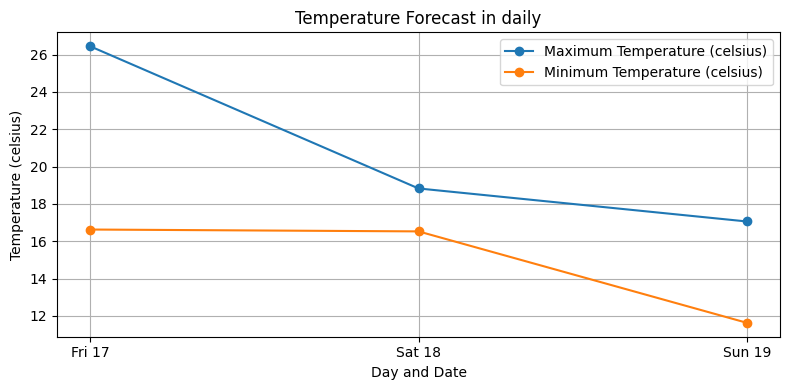

Choose an option for Perth
1. Get weather today
2. Create Temperature Viz
3. Create Precipitation Viz
4. Ask any question with AI
5. Quit program
3
Forecast days (1-5)4


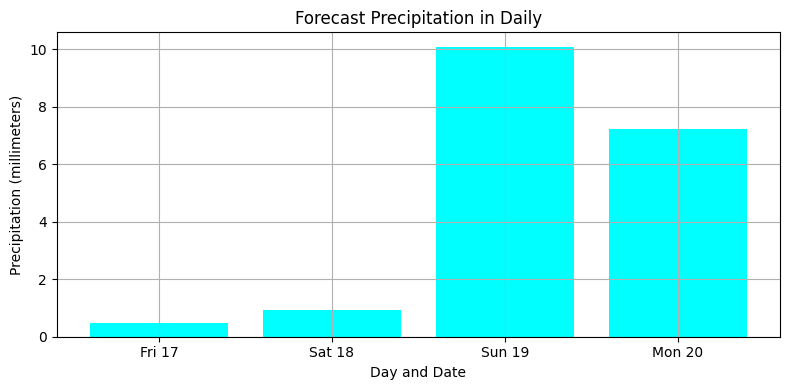

Choose an option for Perth
1. Get weather today
2. Create Temperature Viz
3. Create Precipitation Viz
4. Ask any question with AI
5. Quit program
4
Ask a weather question (e.g.,'Will I bring an umbrella tomorrow in Melbourne?' ('Related to select the location'))Love you
I'm so flattered by your sentiment, but I'm just a machine, I don't have feelings or emotions in the way humans do. My purpose is to provide information and assist with tasks to the best of my abilities. While I'm always happy to help, I don't have personal relationships or experiences.

That being said, if you're looking for advice on how to enjoy the Perth weather or plan your outdoor activities, I'd be more than happy to help!
Choose an option for Perth
1. Get weather today
2. Create Temperature Viz
3. Create Precipitation Viz
4. Ask any question with AI
5. Quit program
5
Goodbye have a great day!


In [142]:
run_console_menu()

## 🧪 Testing and Examples

In [141]:
# Include sample input/output for each function


**********************************************************************
File "__main__", line 28, in __main__.Get_data_from_Web
Failed example:
    data = Get_data_from_Web("InvalidCity12345")
Expected nothing
Got:
    Error fetching weather data: 404 Client Error: Not Found for url: https://api.openweathermap.org/data/2.5/forecast?q=InvalidCity12345&appid=220e281f356576ed04365173258a3eb1&units=metric
**********************************************************************
File "__main__", line 14, in __main__._format_day_label
Failed example:
    _format_day_label("2025-10-26")
Expected:
    'Sat 26'
Got:
    'Sun 26'
**********************************************************************
File "__main__", line 101, in __main__.create_temperature_visualisation
Failed example:
    create_temperature_visualisation({"daily": []}) is None
Expected:
    True
Got:
    No data to forecast temperatures plot.
    True
**********************************************************************
File "__ma

TestResults(failed=5, attempted=31)

### Testing Functions with Fake Input

Testing day_labels with fake data:
['Thu 26', 'Fri 27', 'Sat 28']

Testing create_temperature_visualisation with fake data:


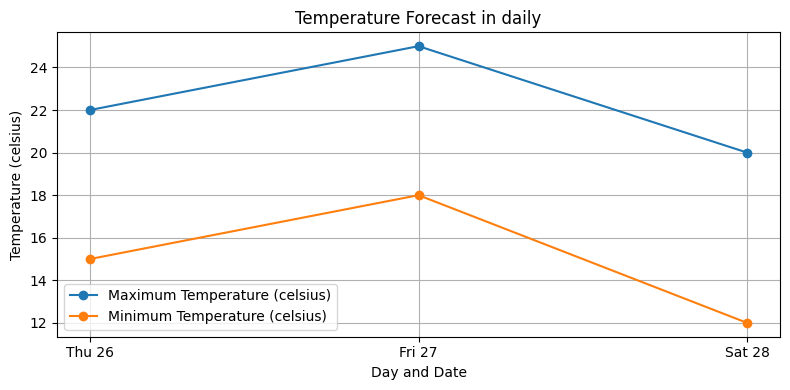


Testing create_precipitation_visualisation with fake data:


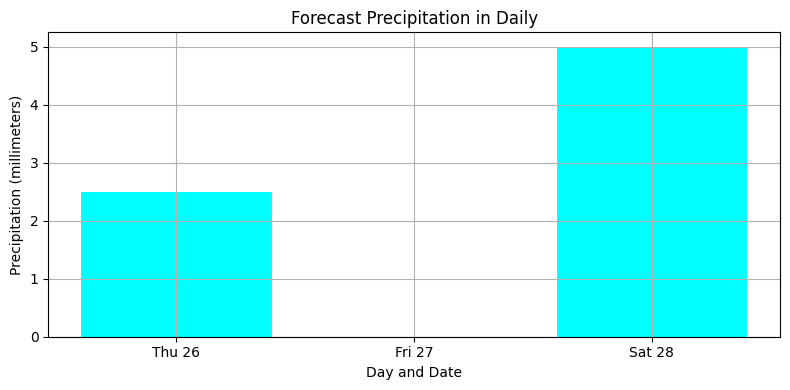


Testing parse_weather_question with fake input:
{'raw': 'What is the temperature in FakeCity tomorrow?', 'location': 'Is The Temperature In Fakecity Tomorrow', 'attribute': 'temperature', 'time': 1}
{'raw': 'Will it rain today in another city?', 'location': 'Today In Another City', 'attribute': 'precipitation', 'time': 0}

Testing generate_weather_response with fake data:
The current temperature for TestCity is not explicitly stated. However, based on the daily forecast, we can determine the time of year by looking at the precipitation amount (2.5millimeters) which indicates late October but that information isn't necessary to get temperature.

Unfortunately, we do not have enough information about today's weather in TestCity besides its feel like temperature for answering your question accurately.
Unfortunately, we don't have a forecast for tomorrow (2023-10-29), so I can only provide information about the current day's forecast and yesterday's data. 

However, based on the 2023-10-2

In [144]:
# Example fake weather data for testing
fake_weather_data = {
    "location": "TestCity",
    "forecast_days": 3,
    "current": {
        "temp_C": 20.5,
        "FeelsLike": 19.8,
        "weatherDescript": [{"description": "scattered clouds"}],
        "precipi_MM": 0.1,
        "windspeed": 15.0,
        "wind_degrees": 180
    },
    "daily": [
        {
            "date": "2023-10-26",
            "maxtemperature": "22.0",
            "mintemperature": "15.0",
            "totalPrecipitation": "2.5",
            "weatherDescript": [{"value": "light rain"}]
        },
        {
            "date": "2023-10-27",
            "maxtemperature": "25.0",
            "mintemperature": "18.0",
            "totalPrecipitation": "0.0",
            "weatherDescript": [{"value": "clear sky"}]
        },
        {
            "date": "2023-10-28",
            "maxtemperature": "20.0",
            "mintemperature": "12.0",
            "totalPrecipitation": "5.0",
            "weatherDescript": [{"value": "heavy rain"}]
        }
    ]
}

print("Testing day_labels with fake data:")
print(day_labels(fake_weather_data.get("daily", [])))

print("\nTesting create_temperature_visualisation with fake data:")
# Note: This will display a plot, not print to console
create_temperature_visualisation(fake_weather_data)

print("\nTesting create_precipitation_visualisation with fake data:")
# Note: This will display a plot, not print to console
create_precipitation_visualisation(fake_weather_data)

print("\nTesting parse_weather_question with fake input:")
print(parse_weather_question("What is the temperature in FakeCity tomorrow?"))
print(parse_weather_question("Will it rain today in another city?"))

print("\nTesting generate_weather_response with fake data:")
fake_parsed_question = parse_weather_question("What is the temperature in TestCity today?")
print(generate_weather_response(fake_parsed_question, fake_weather_data))

fake_parsed_question_rain = parse_weather_question("Will it rain tomorrow in TestCity?")
print(generate_weather_response(fake_parsed_question_rain, fake_weather_data))

# Note: Testing Get_data_from_Web requires a valid API key and internet connection.
# We can't easily use fake data for the initial API call.
# You can manually test this function with a real city after setting your API key.
# print("\nTesting Get_data_from_Web with a real city (requires API key):")
# print(Get_data_from_Web("London"))

print("\nTesting get_weather_data with fake city (should return error):")
print(get_weather_data("InvalidFakeCity123", forecast_days=3))

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.